In [1]:
!pip install shap scipy

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from scipy import stats
matplotlib.style.use('ggplot')

## Data

In [3]:
unscaled_data = pd.read_csv('./data/feature_selection/resale_feature_selection_not_scaled.csv')
unscaled_data['price_per_sqm'] = unscaled_data['resale_price']/unscaled_data['floor_area_sqm']
train_df, test_df = train_test_split(unscaled_data, test_size=0.3, random_state=4248)

In [4]:
train_y = train_df['price_per_sqm']
train_x = train_df.drop(['price_per_sqm', 'floor_area_sqm', 'resale_price'], axis=1)

test_y = test_df['price_per_sqm']
test_x = test_df.drop(['price_per_sqm', 'floor_area_sqm', 'resale_price'], axis=1)

In [5]:
train_price_y = train_df['resale_price']
train_price_x = train_df.drop(['price_per_sqm', 'resale_price'], axis=1)

test_price_y = test_df['resale_price']
test_price_x = test_df.drop(['price_per_sqm', 'resale_price'], axis=1)

In [6]:
def train_and_evaluate(model, parameters):
    train_n = train_x.shape[0]
    train_p = train_x.shape[1]
    test_n = test_x.shape[0]
    test_p = test_x.shape[1]

    grid_model = GridSearchCV(estimator=model(), param_grid=parameters, cv=5, n_jobs=3, verbose=1)
    grid_model.fit(train_x, train_y)
    print(" Results from Grid Search " )
    print("\n The best estimator across ALL searched params:\n", grid_model.best_estimator_)
    print("\n The best score across ALL searched params:\n", grid_model.best_score_)
    print("\n The best parameters across ALL searched params:\n", grid_model.best_params_)
    print()
    pred_y = grid_model.predict(test_x)
    print(f"RMSE: {mean_squared_error(pred_y * test_df['floor_area_sqm'], test_df['resale_price'], squared=False)}")
    print(f"MSE: {mean_squared_error(pred_y * test_df['floor_area_sqm'], test_df['resale_price'], squared=True)}")
    print(f"MAPE: {mean_absolute_percentage_error(pred_y * test_df['floor_area_sqm'], test_df['resale_price'])}" )
    print(f"AdjR2: {1 - (1 - r2_score(test_df['resale_price'], pred_y * test_df['floor_area_sqm'])) * (test_n - 1) / (test_n - test_p - 1)}")
    print()
    plt.scatter(pred_y * test_df['floor_area_sqm'], test_df['resale_price'] - pred_y * test_df['floor_area_sqm'])
    plt.xlabel("Predicted Price")
    plt.ylabel("Residual")
    plt.title("Test Residual Plot")
    plt.show()
    train_score_1, test_score_1 = grid_model.score(train_x, train_y), grid_model.score(test_x, test_y)

    grid_model_2 = GridSearchCV(estimator=model(), param_grid=parameters, cv=5, n_jobs=3, verbose=1)
    grid_model_2.fit(train_price_x, train_price_y)
    print(" Results from Grid Search " )
    print("\n The best estimator across ALL searched params:\n", grid_model_2.best_estimator_)
    print("\n The best score across ALL searched params:\n", grid_model_2.best_score_)
    print("\n The best parameters across ALL searched params:\n", grid_model_2.best_params_)
    print()
    pred_price_y = grid_model_2.predict(test_price_x)
    print(f"RMSE: {mean_squared_error(pred_price_y, test_price_y, squared=False)}")
    print(f"MSE: {mean_squared_error(pred_price_y, test_price_y, squared=True)}")
    print(f"MAPE: {mean_absolute_percentage_error(pred_price_y, test_price_y)}" )
    print(f"AdjR2: {1 - (1 - r2_score(test_price_y, pred_price_y)) * (test_n - 1) / (test_n - test_p - 1)}")
    print()
    plt.scatter(pred_price_y, test_price_y - pred_price_y)
    plt.xlabel("Predicted Price")
    plt.ylabel("Residual")
    plt.title("Test Residual Plot")
    plt.show()
    train_score_2, test_score_2 = grid_model_2.score(train_price_x, train_price_y), grid_model_2.score(test_price_x, test_price_y)

    print('TRAIN')
    print('Using price_per_sqm:', train_score_1)
    print('Using resale_price:', train_score_2)
    print()
    print('TEST')
    print('Using price_per_sqm:', test_score_1)
    print('Using resale_price:', test_score_2)
    print()

    return grid_model, grid_model_2

## Random Forest Regressor

Fitting 5 folds for each of 27 candidates, totalling 135 fits
 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=20, n_estimators=500)

 The best score across ALL searched params:
 0.8674753136222717

 The best parameters across ALL searched params:
 {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 500}

RMSE: 42253.64358694712
MSE: 1785370396.3727574
MAPE: 0.05086220377472498
AdjR2: 0.9344588028997032



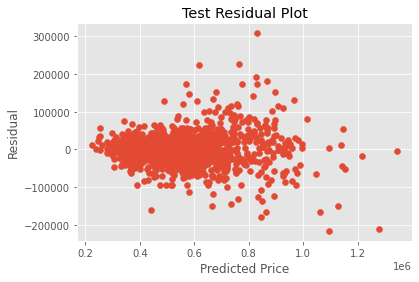

Fitting 5 folds for each of 27 candidates, totalling 135 fits
 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestRegressor()

 The best score across ALL searched params:
 0.903542403810928

 The best parameters across ALL searched params:
 {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

RMSE: 46938.72060557126
MSE: 2203243492.08788
MAPE: 0.055316309293489255
AdjR2: 0.9191186230777355



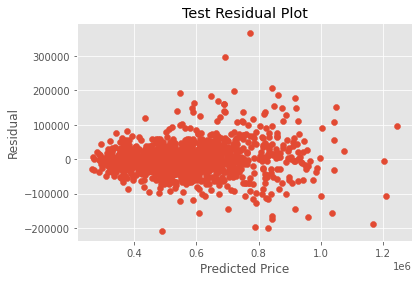

TRAIN
Using price_per_sqm: 0.9840076178189885
Using resale_price: 0.9879572317638464

TEST
Using price_per_sqm: 0.8911660142887294
Using resale_price: 0.9235848413192826



In [7]:
parameters = {
    'n_estimators'      : [10, 100, 500],
    'max_depth'         : [10, 20, None],
    'min_samples_split' : [2, 5, 10]
}
m1, m2 = train_and_evaluate(RandomForestRegressor, parameters)

## Bagging Regressor

Fitting 5 folds for each of 12 candidates, totalling 60 fits
 Results from Grid Search 

 The best estimator across ALL searched params:
 BaggingRegressor(n_estimators=100)

 The best score across ALL searched params:
 0.8665704218147925

 The best parameters across ALL searched params:
 {'max_samples': 1.0, 'n_estimators': 100}

RMSE: 42089.958783943934
MSE: 1771564630.434099
MAPE: 0.05076847163239013
AdjR2: 0.9349656144993268



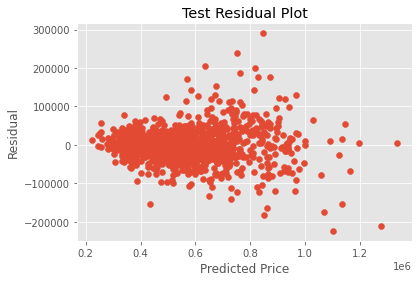

Fitting 5 folds for each of 12 candidates, totalling 60 fits
 Results from Grid Search 

 The best estimator across ALL searched params:
 BaggingRegressor(n_estimators=30)

 The best score across ALL searched params:
 0.9019036041550578

 The best parameters across ALL searched params:
 {'max_samples': 1.0, 'n_estimators': 30}

RMSE: 48277.44898992802
MSE: 2330712080.9751024
MAPE: 0.05725793588440524
AdjR2: 0.9144392333413943



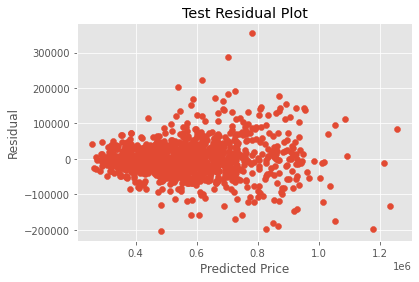

TRAIN
Using price_per_sqm: 0.9841546200394318
Using resale_price: 0.9860053492971201

TEST
Using price_per_sqm: 0.8926049029169024
Using resale_price: 0.9191638445108937



In [17]:
parameters = {
    'n_estimators': [10, 30, 50, 100],
    'max_samples': [0.25, 0.5, 1.0]
}
m1, m2 = train_and_evaluate(BaggingRegressor, parameters)

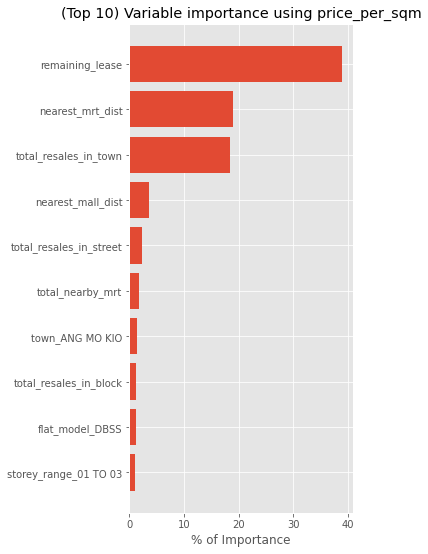

In [18]:
plt.figure(figsize=(4, 9))
importances = np.mean(np.array([dt.feature_importances_ for dt in m1.best_estimator_.estimators_]), axis=0)
sorted_idx = np.argsort(importances)[-10:]
plt.barh(test_x.columns[sorted_idx], 100*importances[sorted_idx])
plt.xlabel('% of Importance')
plt.title('(Top 10) Variable importance using price_per_sqm')
plt.show()

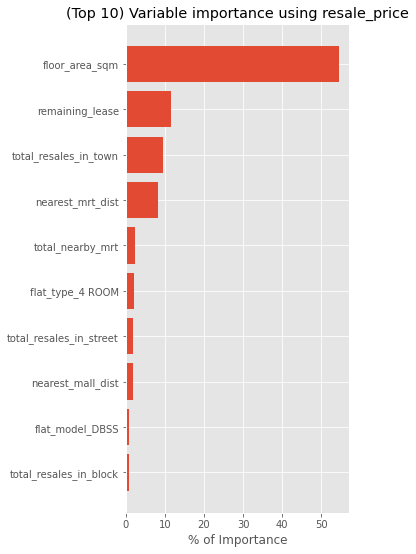

In [19]:
plt.figure(figsize=(4, 9))
importances = np.mean(np.array([dt.feature_importances_ for dt in m2.best_estimator_.estimators_]), axis=0)
sorted_idx = np.argsort(importances)[-10:]
plt.barh(test_price_x.columns[sorted_idx], 100*importances[sorted_idx])
plt.xlabel('% of Importance')
plt.title('(Top 10) Variable importance using resale_price')
plt.show()

## Lasso Regression
$(1 / (2 * n_{samples})) * ||y - Xw||^2_2 + \alpha * ||w||_1$

Fitting 5 folds for each of 18 candidates, totalling 90 fits
 Results from Grid Search 

 The best estimator across ALL searched params:
 Lasso(alpha=0.05, max_iter=10000)

 The best score across ALL searched params:
 0.8321556633908885

 The best parameters across ALL searched params:
 {'alpha': 0.05, 'max_iter': 10000}

RMSE: 49333.700614474816
MSE: 2433814016.3186326
MAPE: 0.0665172230947111
AdjR2: 0.9106543468665759



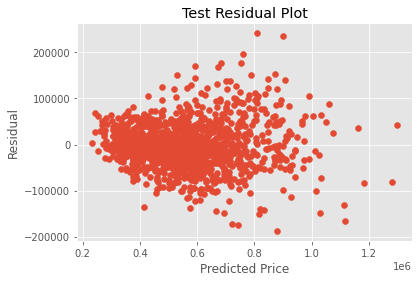

Fitting 5 folds for each of 18 candidates, totalling 90 fits
 Results from Grid Search 

 The best estimator across ALL searched params:
 Lasso(alpha=10, max_iter=10000)

 The best score across ALL searched params:
 0.8895070307475461

 The best parameters across ALL searched params:
 {'alpha': 10, 'max_iter': 10000}

RMSE: 52623.79850001417
MSE: 2769264168.5700936
MAPE: 0.07518472763015036
AdjR2: 0.8983399248336437



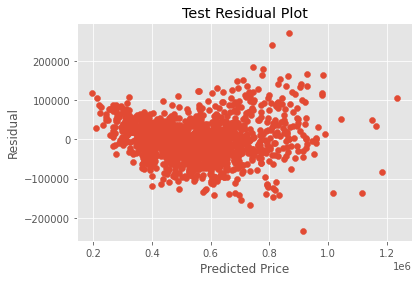

TRAIN
Using price_per_sqm: 0.8494220056332313
Using resale_price: 0.90107642580969

TEST
Using price_per_sqm: 0.8455021782924822
Using resale_price: 0.9039535295894259



In [11]:
parameters = {
    'alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50],
    'max_iter': [10000, 50000]
}
m1, m2 = train_and_evaluate(Lasso, parameters)

In [12]:
print('Using price_per_sqm')
print(dict(zip(test_x.columns[:3], m1.best_estimator_.coef_[:3])))
print('Using resale_price')
print(dict(zip(test_price_x.columns[:4], m2.best_estimator_.coef_[:4])))

Using price_per_sqm
{'total_resales_in_town': -5.161742464495376, 'nearest_mrt_dist': -369.1629837081054, 'remaining_lease': 63.150948039244426}
Using resale_price
{'floor_area_sqm': 5226.204207530446, 'total_resales_in_town': -487.8176570587973, 'nearest_mrt_dist': -32700.38068888092, 'remaining_lease': 5585.818233950848}


## Ridge Regression
$||y - Xw||^2_2 + \alpha * ||w||^2_2$

Fitting 5 folds for each of 45 candidates, totalling 225 fits
 Results from Grid Search 

 The best estimator across ALL searched params:
 Ridge(alpha=1, max_iter=1000)

 The best score across ALL searched params:
 0.8337657522879514

 The best parameters across ALL searched params:
 {'alpha': 1, 'max_iter': 1000}

RMSE: 49317.588269997104
MSE: 2432224512.768956
MAPE: 0.06653335443767361
AdjR2: 0.9107126977643238



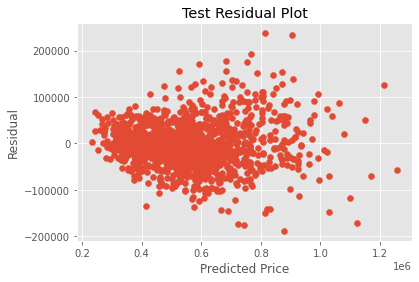

Fitting 5 folds for each of 45 candidates, totalling 225 fits
 Results from Grid Search 

 The best estimator across ALL searched params:
 Ridge(alpha=1, max_iter=1000)

 The best score across ALL searched params:
 0.8904030192043949

 The best parameters across ALL searched params:
 {'alpha': 1, 'max_iter': 1000}

RMSE: 52715.6282066038
MSE: 2778937457.2168818
MAPE: 0.07524172577585853
AdjR2: 0.8979848170537146



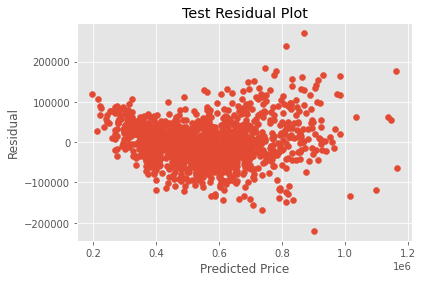

TRAIN
Using price_per_sqm: 0.8487127980662255
Using resale_price: 0.9006859451633299

TEST
Using price_per_sqm: 0.845722393803419
Using resale_price: 0.9036180306354686



In [13]:
parameters = {
    'alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50],
    'max_iter': [1000, 3000, 5000, 10000, 50000]
}
m1, m2 = train_and_evaluate(Ridge, parameters)

In [14]:
print('Using price_per_sqm')
print(dict(zip(test_x.columns[:3], m1.best_estimator_.coef_[:3])))
print('Using resale_price')
print(dict(zip(test_price_x.columns[:4], m2.best_estimator_.coef_[:4])))

Using price_per_sqm
{'total_resales_in_town': -5.210500860630436, 'nearest_mrt_dist': -379.24859766333975, 'remaining_lease': 63.63971960375359}
Using resale_price
{'floor_area_sqm': 5210.656126099369, 'total_resales_in_town': -492.0750695229306, 'nearest_mrt_dist': -33605.47537811032, 'remaining_lease': 5614.191714901921}


## ElasticNet Regression
$1 / (2 * n_{samples}) * ||y - Xw||^2_2 + \alpha * l1_{ratio} * ||w||_1 + 0.5 * \alpha * (1 - l1_{ratio}) * ||w||^2_2$

Fitting 5 folds for each of 135 candidates, totalling 675 fits
 Results from Grid Search 

 The best estimator across ALL searched params:
 ElasticNet(alpha=0.001, max_iter=3000)

 The best score across ALL searched params:
 0.8337388712181502

 The best parameters across ALL searched params:
 {'alpha': 0.001, 'l1_ratio': 0.5, 'max_iter': 3000}

RMSE: 49330.91701427542
MSE: 2433539373.4693284
MAPE: 0.06654964096889816
AdjR2: 0.9106644290440081



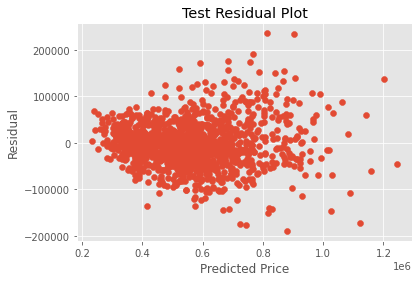

Fitting 5 folds for each of 135 candidates, totalling 675 fits
 Results from Grid Search 

 The best estimator across ALL searched params:
 ElasticNet(alpha=0.001)

 The best score across ALL searched params:
 0.8904372491320327

 The best parameters across ALL searched params:
 {'alpha': 0.001, 'l1_ratio': 0.5, 'max_iter': 1000}

RMSE: 52786.62103940151
MSE: 2786427360.7573857
MAPE: 0.07529515445270518
AdjR2: 0.8977098616465857



c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4454977330532.94, tolerance: 8725634172.54874
  model = cd_fast.enet_coordinate_descent(


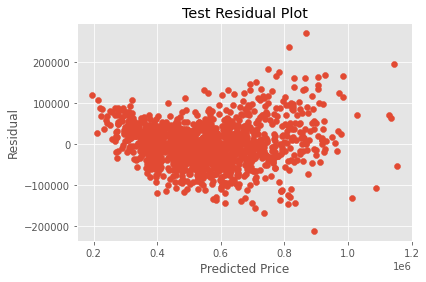

TRAIN
Using price_per_sqm: 0.848100586839195
Using resale_price: 0.9003028029726797

TEST
Using price_per_sqm: 0.8455970878164325
Using resale_price: 0.9033582580912145



In [15]:
parameters = {
    'alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50],
    'l1_ratio': [0.2, 0.5, 0.8],
    'max_iter': [1000, 3000, 5000, 10000, 50000]
}
m1, m2 = train_and_evaluate(ElasticNet, parameters)

In [16]:
print('Using price_per_sqm')
print(dict(zip(test_x.columns[:3], m1.best_estimator_.coef_[:3])))
print('Using resale_price')
print(dict(zip(test_price_x.columns[:4], m2.best_estimator_.coef_[:4])))

Using price_per_sqm
{'total_resales_in_town': -5.232103944728176, 'nearest_mrt_dist': -382.9537076299686, 'remaining_lease': 63.90493056446854}
Using resale_price
{'floor_area_sqm': 5226.6213560332535, 'total_resales_in_town': -494.2279091694513, 'nearest_mrt_dist': -34046.35209046231, 'remaining_lease': 5639.998219106059}
